# 3 - Albedo reflector optimization - Mandy Lewis bifiPV Talk

Artificial Reflector on Single-Axis-Tracked PV System
Modelling a PV test site in Golden, Colorado with 70% reflective artificial reflectors under the modules


In [ ]:
## 0. Setup 

%%bash
wget https://github.com/LBNL-ETA/Radiance/releases/download/012cb178/Radiance_012cb178_Linux.zip -O radiance.zip
unzip radiance.zip
tar -xvf radiance-5.3.012cb17835-Linux.tar.gz;


In [ ]:
!pip install git+https://github.com/NREL/bifacial_radiance.git@development

In [ ]:
import os
os.environ['PATH'] += ":radiance-5.3.012cb17835-Linux/usr/local/radiance/bin"
os.environ['LIBRARYPATH'] += ":radiance-5.3.012cb17835-Linux/usr/local/radiance/lib"
os.environ['RAYPATH'] = ":radiance-5.3.012cb17835-Linux/usr/local/radiance/lib"

In [1]:
import bifacial_radiance as br
from bifacial_radiance import *
import numpy as np
import pandas as pd
import os

# This information helps with debugging and getting support :)
import sys, platform
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("bifacial_radiance version ", br.__version__)

Working on a  Windows 10
Python version  3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]
Pandas version  2.1.0
bifacial_radiance version  0.4.2+223.g58332d6.dirty


## Inputs for location, PV system, reflectors, etc

In [2]:
test_folder = 'Mandy' 
if not os.path.exists(test_folder):
    os.makedirs(test_folder)  

sensorsy = 5

#DOHA
lat = 25.2854 
lon = 51.5310 

# Module parameters
num_panels = 1 #1-UP system, number of panels on collector
module_x = 1 #assume 1 meter width
module_y = 2 #assume 2 meter length
xgap = 0.05 #assume 5 cm gap between modules
ygap = 0.0 #m, 1-UP system
zgap = 0.055 # m

# Torquetube PArameters
diameter = 0.130175 # 5 1/8 in
visible = True 
material = 'Metal_Grey'
tubetype = 'round'
axisofrotation = False

tubeParams = {'tubetype':tubetype,
              'diameter':diameter,
              'material':material,
              'axisofrotation':axisofrotation,
              'visible':visible}

# Scene Parameters
axis_azimuth = 90 # SAT modules with N/S axis are 'facing east', and tilt angle changes to face east vs west.
axis_tilt = 0
hub_height = 1.5 # m
albedo = 0.2 #Assume non-reflecting ground surface has albedo of ~0.2
nMods = 7 
nRows = 3 
pitch = 5.7 #pitch in m
GCR = module_y/pitch 

## Get up module CEC parameters

In [3]:
#Set up module parameters
bf = 0.7
url = 'https://raw.githubusercontent.com/NREL/SAM/patch/deploy/libraries/CEC%20Modules.csv'
db = pd.read_csv(url, index_col=0) # Reading this might take 1 min or so, the database is big.
# print(db)
modfilter2 = db.index.str.startswith('LONGi') & db.index.str.endswith('LR6-60HIBD-305M')
CECMod = db[modfilter2]
print(len(CECMod), " modules selected. Name of 1st entry: ", CECMod.index[0])
Module_power = CECMod['STC'].values[0]
print(Module_power)
#Set up system parameters
DCACratio = 1.2

1  modules selected. Name of 1st entry:  LONGi Green Energy Technology Co. Ltd. LR6-60HIBD-305M
305.52


## Set up reflector parameters


In [4]:
reflector_length = 1.0 #m reflector length 
reflector_width = (nMods*(module_x+xgap))-xgap #reflectors end flush with edges of modules to N and S; equivalent to ROW Width
reflector_offset = 0 #m  reflector location, center with respect to torque tube
reflectance = 0.7 #% reflectance

In [5]:
#Create new material for ground-reflecting material:
description = 'Custom reflecting ground sheet material'
ref_material_name = 'Ground_sheet'
#Start with (spectrally-invarying) albedo given
Rrefl = reflectance
Grefl = reflectance
Brefl = reflectance

## Make Modules and Reflectors objects

In [6]:
demo = br.RadianceObj('Mandy_reflectors',path = test_folder)  
epwfile = demo.getEPW(39.7407, -105.1686) # Golden, CO
#Valid options: mm_dd, mm_dd_HH, mm_dd_HHMM, YYYY-mm-dd_HHMM
metdata = demo.readWeatherFile(epwfile, coerce_year=2023, starttime='2023-12-04', endtime='2023-12-04')

path = Mandy
Getting weather file: USA_CO_Golden-NREL.724666_TMY3.epw
 ... OK!
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2023
Filtering dates
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos


In [7]:
PV_module = demo.makeModule(name='PV_module',x=module_x,y=module_y,numpanels = num_panels, xgap=xgap, ygap=ygap)

demo.addMaterial(material=ref_material_name, Rrefl=reflectance, Grefl=reflectance, Brefl=reflectance, comment=description)
reflector_name = 'reflector_'+str(reflector_length)+'m'
reflector_module = demo.makeModule(name=reflector_name,x=reflector_width,y=reflector_length,numpanels = 1, 
                                   xgap=0, ygap=0,modulematerial=ref_material_name)



Module Name: PV_module
Module PV_module updated in module.json
Pre-existing .rad file objects\PV_module.rad will be overwritten

Material exists, overwriting...

Added material Ground_sheet to file ground.rad

Module Name: reflector_1.0m
Module reflector_1.0m updated in module.json
Pre-existing .rad file objects\reflector_1.0m.rad will be overwritten



## Run bifacial_radiance comparison 


In [8]:
metdata.datetime

[Timestamp('2023-12-04 08:00:00-0700', tz='UTC-07:00'),
 Timestamp('2023-12-04 09:00:00-0700', tz='UTC-07:00'),
 Timestamp('2023-12-04 10:00:00-0700', tz='UTC-07:00'),
 Timestamp('2023-12-04 11:00:00-0700', tz='UTC-07:00'),
 Timestamp('2023-12-04 12:00:00-0700', tz='UTC-07:00'),
 Timestamp('2023-12-04 13:00:00-0700', tz='UTC-07:00'),
 Timestamp('2023-12-04 14:00:00-0700', tz='UTC-07:00'),
 Timestamp('2023-12-04 15:00:00-0700', tz='UTC-07:00'),
 Timestamp('2023-12-04 16:00:00-0700', tz='UTC-07:00'),
 Timestamp('2023-12-04 17:00:00-0700', tz='UTC-07:00')]

In [26]:
for ts in range(0,len(metdata.datetime)):
    print("timestamp:"+str(ts), metdata.datetime[ts])
    ts_string = str(ts).zfill(4)
    ghi_ts = metdata.ghi[ts]    

    tilt = demo.getSingleTimestampTrackerAngle(timeindex=ts, metdata=metdata, gcr=GCR, azimuth=180, axis_tilt=0, limit_angle=50, backtrack=True)         

    demo.setGround(metdata.albedo[ts])
    demo.gendaylit(ts)
    sceneDict1 = {'tilt':tilt,'pitch': pitch,'hub_height':hub_height,'azimuth':axis_azimuth, 'nMods': nMods, 'nRows': nRows}  
    scene1 = demo.makeScene(module=PV_module, sceneDict=sceneDict1) #makeScene creates a .rad file with 20 modules per row, 7 rows.
    octfile = demo.makeOct(demo.getfilelist()) 
    analysis = AnalysisObj(octfile, demo.basename)  # return an analysis object including the scan dimensions for back irradiance
    frontscan, backscan = analysis.moduleAnalysis(scene1, sensorsy=3)
    analysis.analysis(octfile, 'Reference_ts'+ts_string, frontscan, backscan)  # compare the back vs front irradiance  

    #FULL TEST W/REFLECTOR
    sceneDict2 = {'tilt':0,'pitch': pitch,'clearance_height':0,'azimuth':axis_azimuth, 'nMods': 1, 'nRows': nRows,'originy': 0,'originx':reflector_offset,'appendRadfile':True}             
    scene2 = demo.makeScene(module=reflector_module, sceneDict=sceneDict2)
    octfile = demo.makeOct(demo.getfilelist()) 
    analysis = AnalysisObj(octfile, demo.basename)  # return an analysis object including the scan dimensions for back irradiance
    frontscan, backscan = analysis.moduleAnalysis(scene1, sensorsy=3)
    analysis.analysis(octfile, 'reflector_'+str(reflector_length)+'m_ts'+ts_string, frontscan, backscan)  # compare the back vs front irradiance  


timestamp:0 2023-12-04 08:00:00-07:00
Loading albedo, 1 value(s), 0.210 avg
1 nonzero albedo values.
Created Mandy_reflectors.oct
Linescan in process: Reference_ts0000_Row2_Module4_Front
Linescan in process: Reference_ts0000_Row2_Module4_Back
Saved: results\irr_Reference_ts0000_Row2_Module4.csv
Created Mandy_reflectors.oct
Linescan in process: reflector_1.0m_ts0000_Row2_Module4_Front
Linescan in process: reflector_1.0m_ts0000_Row2_Module4_Back
Saved: results\irr_reflector_1.0m_ts0000_Row2_Module4.csv
timestamp:1 2023-12-04 09:00:00-07:00
Loading albedo, 1 value(s), 0.210 avg
1 nonzero albedo values.
Created Mandy_reflectors.oct
Linescan in process: Reference_ts0001_Row2_Module4_Front
Linescan in process: Reference_ts0001_Row2_Module4_Back
Saved: results\irr_Reference_ts0001_Row2_Module4.csv
Created Mandy_reflectors.oct
Linescan in process: reflector_1.0m_ts0001_Row2_Module4_Front
Linescan in process: reflector_1.0m_ts0001_Row2_Module4_Back
Saved: results\irr_reflector_1.0m_ts0001_Row2_

c:\users\sayala\documents\github\bifacial_radiance\bifacial_radiance\main.py:2151: Warning: xform: command line error at '-rx'
oconv: warning - (!xform -rx nan -t 0 0 1.5 -a 7 -t 1.05 0 0 -a 3 -t 0 5.7 0 -i 1 -t -3.1500000000000004 -5.7 0 -rz 90 -t 0 0 0 objects\PV_module.rad): empty file
oconv: warning - (objects\PV_module_C_nan_rtr_5.70000_tilt_nan_7modsx3rows_origin0,0.rad): empty file
  warnings.warn(err[9:], Warning)


Created Mandy_reflectors.oct
Linescan in process: Reference_ts0009_Row2_Module4_Front
message: xform: command line error at '-rx'
rtrace: warning - (!xform -rx nan -t 0 0 1.5 -a 7 -t 1.05 0 0 -a 3 -t 0 5.7 0 -i 1 -t -3.1500000000000004 -5.7 0 -rz 90 -t 0 0 0 objects\PV_module.rad): empty file
rtrace: warning - (objects\PV_module_C_nan_rtr_5.70000_tilt_nan_7modsx3rows_origin0,0.rad): empty file
Linescan in process: Reference_ts0009_Row2_Module4_Back
message: xform: command line error at '-rx'
rtrace: warning - (!xform -rx nan -t 0 0 1.5 -a 7 -t 1.05 0 0 -a 3 -t 0 5.7 0 -i 1 -t -3.1500000000000004 -5.7 0 -rz 90 -t 0 0 0 objects\PV_module.rad): empty file
rtrace: warning - (objects\PV_module_C_nan_rtr_5.70000_tilt_nan_7modsx3rows_origin0,0.rad): empty file
Created Mandy_reflectors.oct
Linescan in process: reflector_1.0m_ts0009_Row2_Module4_Front
message: xform: command line error at '-rx'
rtrace: warning - (!xform -rx nan -t 0 0 1.5 -a 7 -t 1.05 0 0 -a 3 -t 0 5.7 0 -i 1 -t -3.150000000000

## Summarize output data in pandas dataframe

In [28]:
resultsfolder = os.path.join(test_folder, 'results')

columns = ['Datetime','GHI',
           'avg_FrontIrrad','avg_RearIrrad','avg_TotalIrrad','MAD','Power_DC','Power_AC',\
           'ref_avg_FrontIrrad','ref_avg_RearIrrad','ref_avg_TotalIrrad','ref_MAD','ref_Power_DC','ref_Power_AC',\
           'front_irrGain','rear_irrGain','total_irrGain','total_energyGain_AC']
results_df = pd.DataFrame(columns=columns)

In [29]:
avg_FrontIrrad = []
avg_RearIrrad = []
avg_TotalIrrad = []
MAD = []
Power_DC = []
Power_AC = []

ref_avg_FrontIrrad = []
ref_avg_RearIrrad = []
ref_avg_TotalIrrad = []
ref_MAD = []
ref_Power_DC = []
ref_Power_AC = []

front_irrGain = []
rear_irrGain = []
total_irrGain = []
total_energyGain_AC = []
timestamp_list = []

for ts in range(0,len(metdata.datetime)):
    ts_string = str(ts).zfill(4)
    temp_air = metdata.temp_air[ts]
    wind_speed = metdata.wind_speed[ts]
    ghi_ts = metdata.ghi[ts] 
    results_df.loc[ts,'GHI']=ghi_ts
    results_df.loc[ts,'Datetime']=metdata.datetime[ts]
    tilt = demo.getSingleTimestampTrackerAngle(ts, metdata, gcr=GCR, azimuth=180, axis_tilt=0, limit_angle=50, backtrack=True)
    if ghi_ts != 0 and not np.isnan(tilt):
        timestamp_list.append(ts)
        ts_string = str(ts).zfill(4) 
        sim_name = ('irr_'+reflector_name+'_ts'+ts_string+'_Row2_Module4.csv')
        result_file = os.path.join('results', sim_name)
        
        data = pd.read_csv(result_file)  
        
        FrontIrrad = data['Wm2Front'].to_numpy(dtype='float')
        RearIrrad = data['Wm2Back'].to_numpy(dtype='float')
        TotalIrrad = (bf*RearIrrad)+FrontIrrad
        
        results_df.loc[ts,'avg_FrontIrrad']=FrontIrrad.mean()
        results_df.loc[ts,'avg_RearIrrad']=RearIrrad.mean()
        results_df.loc[ts,'avg_TotalIrrad']=TotalIrrad.mean()
        MAD_ts = mismatch.mad_fn(TotalIrrad)
        results_df.loc[ts,'MAD']=MAD_ts
        
        MMloss_fit=0.054*(MAD_ts) + 0.068*np.square(MAD_ts)
        power_ts = performance.calculatePerformance(TotalIrrad.mean(),temp_air=temp_air,wind_speed=wind_speed,CECMod=CECMod)
        power_DC_ts = power_ts*(1-(MMloss_fit/100))
        results_df.loc[ts,'Power_DC']=power_DC_ts
        power_AC_ts = np.clip(power_DC_ts, 0, Module_power/DCACratio)
        results_df.loc[ts,'Power_AC']=power_AC_ts
        
        
        ref_name = ('irr_Reference_ts'+ts_string+'_Row2_Module4.csv')
        reference_file = os.path.join('results', ref_name)
        data_ref = pd.read_csv(reference_file) 
        
        ref_FrontIrrad = data_ref['Wm2Front'].to_numpy(dtype='float')
        ref_RearIrrad = data_ref['Wm2Back'].to_numpy(dtype='float')
        ref_TotalIrrad = (bf*ref_RearIrrad)+ref_FrontIrrad
        
        results_df.loc[ts,'ref_avg_FrontIrrad']=ref_FrontIrrad.mean()
        results_df.loc[ts,'ref_avg_RearIrrad']=ref_RearIrrad.mean()
        results_df.loc[ts,'ref_avg_TotalIrrad']=ref_TotalIrrad.mean()
        ref_MAD_ts = mismatch.mad_fn(ref_TotalIrrad)
        results_df.loc[ts,'ref_MAD']=ref_MAD_ts
        
        MMloss_fit=0.054*(ref_MAD_ts) + 0.068*np.square(ref_MAD_ts)
        ref_power_ts = performance.calculatePerformance(ref_TotalIrrad.mean(),temp_air=temp_air,wind_speed=wind_speed,CECMod=CECMod)
        ref_Power_DC_ts = ref_power_ts*(1-(MMloss_fit/100))
        results_df.loc[ts,'ref_Power_DC']=ref_Power_DC_ts
        ref_Power_AC_ts = np.clip(ref_Power_DC_ts, 0, Module_power/DCACratio)
        results_df.loc[ts,'ref_Power_AC']=ref_Power_AC_ts
        
        results_df.loc[ts,'front_irrGain'] = 100*((FrontIrrad.mean()-ref_FrontIrrad.mean())/ref_FrontIrrad.mean())
        results_df.loc[ts,'rear_irrGain'] = 100*((RearIrrad.mean()-ref_RearIrrad.mean())/ref_RearIrrad.mean())
        results_df.loc[ts,'total_irrGain'] = 100*((TotalIrrad.mean()-ref_TotalIrrad.mean())/ref_TotalIrrad.mean())
        results_df.loc[ts,'total_energyGain_AC'] = 100*((power_AC_ts-ref_Power_AC_ts)/ref_Power_AC_ts)

# Convert datetime column to datetime values 
results_df['Datetime'] = pd.to_datetime(results_df['Datetime'])
results_df['Datetime'] = results_df['Datetime'].dt.tz_localize(None)
print(results_df)        

c:\users\sayala\documents\github\bifacial_radiance\bifacial_radiance\performance.py:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  alpha_sc=float(CECMod.alpha_sc),
c:\users\sayala\documents\github\bifacial_radiance\bifacial_radiance\performance.py:65: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a_ref=float(CECMod.a_ref),
c:\users\sayala\documents\github\bifacial_radiance\bifacial_radiance\performance.py:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  I_L_ref=float(CECMod.I_L_ref),
c:\users\sayala\documents\github\bifacial_radiance\bifacial_radiance\performance.py:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(

             Datetime  GHI avg_FrontIrrad avg_RearIrrad avg_TotalIrrad  \
0 2023-12-04 08:00:00   31      53.508667      8.311103      59.326439   
1 2023-12-04 09:00:00  101     221.173833     28.095227     240.840492   
2 2023-12-04 10:00:00  263       406.1298     66.313983     452.549588   
3 2023-12-04 11:00:00  391     475.705633      73.87991      527.42157   
4 2023-12-04 12:00:00  436       443.6279     70.110957      492.70557   
5 2023-12-04 13:00:00  330       340.3514      59.49824     382.000168   
6 2023-12-04 14:00:00  393       533.0483     75.808643      586.11435   
7 2023-12-04 15:00:00  292     560.131633     72.924423      611.17873   
8 2023-12-04 16:00:00  133       330.8946      38.37709     357.758563   
9 2023-12-04 17:00:00   12            NaN           NaN            NaN   

        MAD    Power_DC    Power_AC ref_avg_FrontIrrad ref_avg_RearIrrad  \
0   0.30832   19.051136   19.051136          53.554813           5.21588   
1  0.219809   78.928607   78.9286

In [30]:
results_df

,Datetime,GHI,avg_FrontIrrad,avg_RearIrrad,avg_TotalIrrad,MAD,Power_DC,Power_AC,ref_avg_FrontIrrad,ref_avg_RearIrrad,ref_avg_TotalIrrad,ref_MAD,ref_Power_DC,ref_Power_AC,front_irrGain,rear_irrGain,total_irrGain,total_energyGain_AC
0,2023-12-04 08:00:00,31,53.508667,8.311103,59.326439,0.30832,19.051136,19.051136,53.554813,5.21588,57.20593,0.364473,18.349619,18.349619,-0.086167,59.34228,3.706799,3.823062
1,2023-12-04 09:00:00,101,221.173833,28.095227,240.840492,0.219809,78.928607,78.928607,221.025867,18.566333,234.0223,0.991582,76.598557,76.598557,0.066945,51.323507,2.91348,3.041898
2,2023-12-04 10:00:00,263,406.1298,66.313983,452.549588,0.552143,147.659042,147.659042,405.9095,43.394143,436.2854,0.908092,142.360015,142.360015,0.054273,52.817819,3.727878,3.722272
3,2023-12-04 11:00:00,391,475.705633,73.87991,527.42157,0.548472,170.434469,170.434469,475.3273,53.335443,512.66211,0.36853,165.83357,165.83357,0.079594,38.519351,2.878984,2.774407
4,2023-12-04 12:00:00,436,443.6279,70.110957,492.70557,0.116434,160.546557,160.546557,443.412867,56.097147,482.680869,0.204505,157.329223,157.329223,0.048495,24.981324,2.07688,2.044969
5,2023-12-04 13:00:00,330,340.3514,59.49824,382.000168,0.085784,124.058078,124.058078,340.723567,45.155583,372.332475,0.300231,120.92546,120.92546,-0.109228,31.762754,2.596522,2.590537
6,2023-12-04 14:00:00,393,533.0483,75.808643,586.11435,0.75694,188.070143,188.070143,533.272067,51.173553,569.093554,0.270376,182.911501,182.911501,-0.041961,48.140276,2.990861,2.820294
7,2023-12-04 15:00:00,292,560.131633,72.924423,611.17873,0.766518,196.500482,196.500482,559.348633,44.355527,590.397502,0.407135,190.141857,190.141857,0.139984,64.408877,3.519871,3.344148
8,2023-12-04 16:00:00,133,330.8946,38.37709,357.758563,0.304744,116.068826,116.068826,330.736233,24.100987,347.606924,0.32889,112.796362,112.796362,0.047883,59.234518,2.920436,2.901214
9,2023-12-04 17:00:00,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Calculate a few metrics for entire run

In [31]:
""" Summarize Results """
   
sum_FrontIrrad = np.sum(results_df['avg_FrontIrrad'])
sum_RearIrrad = np.sum(results_df['avg_RearIrrad'])
sum_TotalIrrad = np.sum(results_df['avg_TotalIrrad'])
sum_Power_DC = np.sum(results_df['Power_DC'])
sum_Power_AC = np.sum(results_df['Power_AC'])

sum_ref_FrontIrrad = np.sum(results_df['ref_avg_FrontIrrad'])
sum_ref_RearIrrad = np.sum(results_df['ref_avg_RearIrrad'])
sum_ref_TotalIrrad = np.sum(results_df['ref_avg_TotalIrrad'])
sum_ref_Power_DC = np.sum(results_df['ref_Power_DC'])
sum_ref_Power_AC = np.sum(results_df['ref_Power_AC'])

total_front_irrGain = 100*((sum_FrontIrrad-sum_ref_FrontIrrad)/sum_ref_FrontIrrad)
total_rear_irrGain=100*((sum_RearIrrad-sum_ref_RearIrrad)/sum_ref_RearIrrad)
total_total_irrGain=100*((sum_TotalIrrad-sum_ref_TotalIrrad)/sum_ref_TotalIrrad)
total_total_energyGain_AC=100*((sum_Power_AC-sum_ref_Power_AC)/sum_ref_Power_AC)

print("front irradiance gain:\t"+str(np.round(total_front_irrGain,2))+"%")
print("rear irradiance gain:\t"+str(np.round(total_rear_irrGain))+"%")
print("total irradiance gain:\t"+str(np.round(total_total_irrGain))+"%")
print("AC energy gain:\t\t"+str(np.round(total_total_energyGain_AC))+"%")

front irradiance gain:	0.04%
rear irradiance gain:	45.0%
total irradiance gain:	3.0%
AC energy gain:		3.0%


## Plot results - single day example

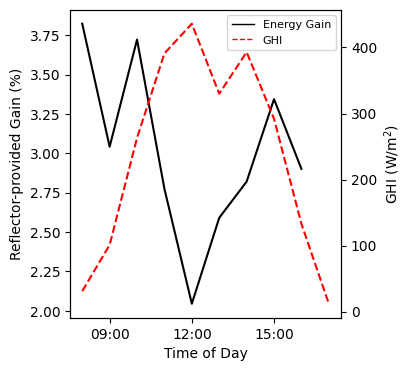

In [33]:
import matplotlib.dates as mdates
import datetime
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

""" PLOT RESULTS """
fig_x = 3.5
fig_y = 4
titlesize = 10
labelsize = 8
lw = 1
markersize = lw*2

view_year = 2021
view_month = 1 #January
view_date = 3 #3rd

fig,ax = plt.subplots(figsize=(fig_x,fig_y)) 
ax2 = ax.twinx()
ax.plot(results_df['Datetime'],results_df['total_energyGain_AC'], ls="-", c="k")
ax2.plot(results_df['Datetime'],results_df['GHI'], ls="--", c="r")
ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
formatter = mdates.DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(formatter)
#ax.set_xlim([datetime.datetime(view_year, view_month,view_date,7,30), datetime.datetime(view_year,view_month,view_date,17,30)])
ax.set_ylabel("Reflector-provided Gain (%)",fontsize=titlesize)
ax2.set_ylabel("GHI (W/m$^2$)",fontsize=titlesize)
ax.set_xlabel("Time of Day",fontsize=titlesize)

custom_lines = [Line2D([0], [0], color='k', lw=lw,linestyle='-'),
                Line2D([0], [0], color='r', lw=lw,linestyle='--')]
custom_labels = ['Energy Gain','GHI']
ax.legend(custom_lines,custom_labels,fontsize=labelsize)